### Cross-contour transport

This notebook uses the cosima cookbook to calculate transport across an arbitrary contour.

Load useful packages

In [2]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import numpy as np
from dask.distributed import Client

In [3]:
import matplotlib
print(matplotlib.__version__)

3.5.1


In [4]:
print(xr.__version__)

0.20.2


In [5]:
from scipy.ndimage.filters import uniform_filter1d, uniform_filter

In [6]:
client = Client(n_workers=4)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 8,Total memory: 22.46 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44637,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 22.46 GiB
Comm: tcp://127.0.0.1:42059,Total threads: 2
Dashboard: /proxy/35273/status,Memory: 5.62 GiB
Nanny: tcp://127.0.0.1:33139,


Choose database

In [7]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')


Choose experiment

In [8]:
expt = '01deg_jra55v13_ryf9091'

Choose a latitude range so the contour fits in the range, but there is not too much extra space

In [9]:
lat_range = slice(-64.99,-47)


Make sure that this latitude range is so that the t-cells are always south and west of the u-cells.

In [10]:
%%time

yt_ocean = cc.querying.getvar(expt,'yt_ocean',session,n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
xt_ocean = cc.querying.getvar(expt,'xt_ocean',session,n=1)
yu_ocean = cc.querying.getvar(expt,'yu_ocean',session,n=1)
yu_ocean = yu_ocean.sel(yu_ocean=lat_range)
xu_ocean = cc.querying.getvar(expt,'xu_ocean',session,n=1)


CPU times: user 10.6 s, sys: 3.42 s, total: 14 s
Wall time: 59.2 s


Load quantity you want a contour of, e.g. SSH averaged over a year

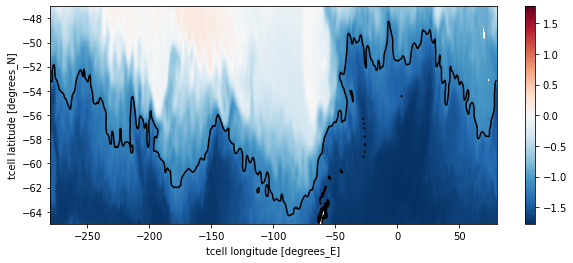

In [11]:
start_time = '2170-01-01'
end_time = '2170-12-31'
time_slice = slice(start_time, end_time)
ssh = cc.querying.getvar(expt,'sea_level', session, start_time = start_time, end_time = end_time)
# select one year and latitude range
ssh = ssh.sel(yt_ocean = lat_range, time = time_slice)
# weighed time mean by month length
month_length = ssh.time.dt.days_in_month
ssh_mean = (ssh*month_length).sum('time')/365

fig = plt.figure(figsize = (10,4))
ssh_mean.plot()
ssh_mean.plot.contour(levels = [-1.2],colors = 'k', linestyles = '-')

In [12]:
ssh_mean.values

array([[-1.68376863, -1.68350453, -1.68304927, ..., -1.68387182,
        -1.68387689, -1.68384308],
       [-1.68404096, -1.68361606, -1.68296457, ..., -1.68449914,
        -1.68443244, -1.6843109 ],
       [-1.68443237, -1.68380246, -1.6830205 , ..., -1.68525987,
        -1.68514444, -1.68485904],
       ...,
       [-0.35304341, -0.35260791, -0.35317526, ..., -0.36131014,
        -0.35743017, -0.35468279],
       [-0.34206178, -0.34111759, -0.34125027, ..., -0.35133587,
        -0.34720367, -0.34408162],
       [-0.33204358, -0.33067438, -0.33028009, ..., -0.34239022,
        -0.3379436 , -0.33451711]])

In [13]:
# Function that smoothed the data in x and y direction
def running_mean_2d(in_data, N):
    in_data  = in_data.load()
    out_data = in_data.copy(deep=True)
    for yy in range(np.shape(in_data)[0]):
        cumsum_tmp = np.nancumsum(np.insert(in_data.values[yy,:], 0, 0))
        out_data[yy,int(N/2):-int(N/2)+1] = (cumsum_tmp[N:] - cumsum_tmp[:-N]) / float(N)  
        #out_data[yy,int(N/2):-int(N/2)] = (cumsum_tmp[N:] - cumsum_tmp[:-N]) / float(N)
    for xx in range(np.shape(in_data)[1]):
        cumsum_tmp = np.nancumsum(np.insert(in_data.values[:,xx], 0, 0))
        out_data[int(N/2):-int(N/2)+1,xx] = (cumsum_tmp[N:] - cumsum_tmp[:-N]) / float(N)
        #out_data[int(N/2):-int(N/2),xx] = (cumsum_tmp[N:] - cumsum_tmp[:-N]) / float(N)
    return out_data

In [14]:
h = ssh_mean.load()
# Fill in land with zeros:
h = h.fillna(0)
#h = running_mean_2d(h, 10)
#h = h*0+uniform_filter(h.values,[10,10],mode = ['reflect','wrap'])

choose contour

In [15]:
contour_depth = -1.20

For matplotlib version 3.4.3, we use the matplotlib contour plotting function and extract the coordinates associated with that contour:

In [16]:
# count = 0
# x_contour = []
# y_contour = []
# # Create the contour:
# sc = plt.contour(h, levels=[contour_depth])
# for collection in sc.collections:
#     for path in collection.get_paths():
#         count += 1
#         #print(np.shape(path.to_polygons()[0]))
#         if count > 3: 
#             # We only need the polygon from the first contour, which is the circumpolar contour
#             break
#         else:
#             # Write down the lat/lon indices
#             for ii in range(np.size(path.to_polygons()[0], 0)):
#                 x_contour.append(int(np.round(path.to_polygons()[0][ii][0])))
#                 y_contour.append(int(np.round(path.to_polygons()[0][ii][1])))

If there are multiple contours satisfying this contour level, change the count in the if statement below until desired contour is highlighted red.

### with the above code in newer matplotlib versions, there are holes. 
Analysis-21.07 uses path.to_polygons() but this does not get the entire path for Analysis-21.10:

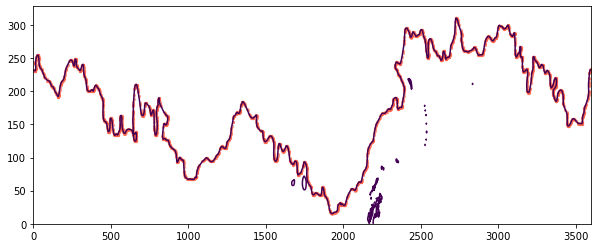

In [17]:
fig = plt.figure(figsize = (10,4))
count = 0
x_contour = []
y_contour = []
# Create the contour:
sc = plt.contour(h, levels=[contour_depth])
for collection in sc.collections:
    for path in collection.get_paths():
        count += 1
        #print(np.shape(path.to_polygons()[0]))
        if count ==  2:
            # For 630 m, t-grid, this is the contour we want
            # Write down the lat/lon indices
            for ii in range(np.size(path.to_polygons()[0], 0)):
                x_contour.append(int(np.round(path.to_polygons()[0][ii][0])))
                y_contour.append(int(np.round(path.to_polygons()[0][ii][1])))
plt.scatter(x_contour, y_contour, s=5, alpha=0.5, color='tomato');

In [18]:
np.size(path.vertices[:,0])

5

In [20]:
a= path.iter_segments(snap = True, stroke_width = 1)
a

<generator object Path.iter_segments at 0x7f55f292d270>

Using path.vertices instead we appear to get a full contour. However, it has fewer points (<5000) than the original in earlier matplotlib version (> 5000), so something is different.

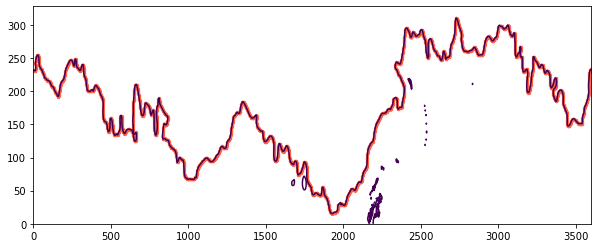

In [21]:
fig = plt.figure(figsize = (10,4))
count = 0
x_contour = []
y_contour = []
# Create the contour:
sc = plt.contour(h, levels=[contour_depth])
for collection in sc.collections:
    for path in collection.get_paths():
        count += 1
        if count ==  2:
            # Write down the lat/lon indices
            for ii in range(np.size(path.vertices[:,0])):
                x_contour.append(int(np.round(path.vertices[ii][0])))
                y_contour.append(int(np.round(path.vertices[ii][1])))
plt.scatter(x_contour, y_contour, s=5, alpha=0.5, color='tomato');

In [22]:
# Difference between two neighbouring indices
diff_x_contour = np.diff(x_contour)
diff_y_contour = np.diff(y_contour)
# Get a list with the indices of duplicates
diff_ind = []
for ii in range(len(diff_x_contour)):
    if (diff_x_contour[ii]==0) and (diff_y_contour[ii]==0):
        diff_ind.append(ii)


In [23]:
# # Now remove the indices (start from the end so the indices don't shift)
for ii in range(len(diff_ind)):
    index = diff_ind[::-1][ii]
    del x_contour[index]
    del y_contour[index]

In [24]:
h_contour = np.zeros(len(x_contour))#np.zeros_like(x_contour)
for ii in range(len(h_contour)):
    h_contour[ii] = h[y_contour[ii], x_contour[ii]]

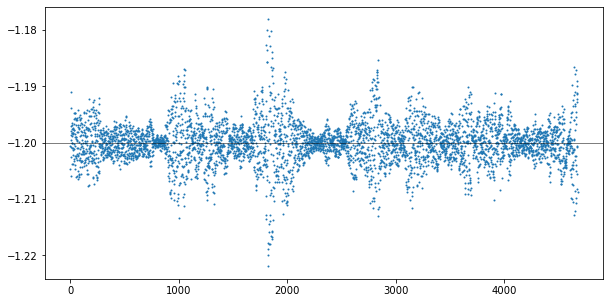

In [25]:
fig = plt.figure(figsize=(10,5))
plt.plot(h_contour, 'o', markersize=1)
plt.axhline(contour_depth, color='k', linewidth=0.5);

In [26]:
# Number of grid points on the contour
num_points = len(x_contour)

In [27]:
x_var = xt_ocean
y_var = yt_ocean

In [28]:
# Get lat and lon along the contour
lat_along_contour = np.zeros((num_points))
lon_along_contour = np.zeros((num_points))

for ii in range(len(h_contour)):
    lon_along_contour[ii] = x_var[x_contour[ii]]
    lat_along_contour[ii] = y_var[y_contour[ii]]

In [29]:
contour_mask_numbered = np.zeros_like(lon_along_contour)

for ii in range(num_points-1):
    lat1 = lat_along_contour[ii]
    lat2 = lat_along_contour[ii+1]
    lon1 = lon_along_contour[ii]
    lon2 = lon_along_contour[ii+1]
    contour_mask_numbered[ii] = ii

In [30]:
contour_mask = h*0
for ii in range(num_points-1):
    contour_mask[y_contour[ii],x_contour[ii]] = contour_mask_numbered[ii]+1


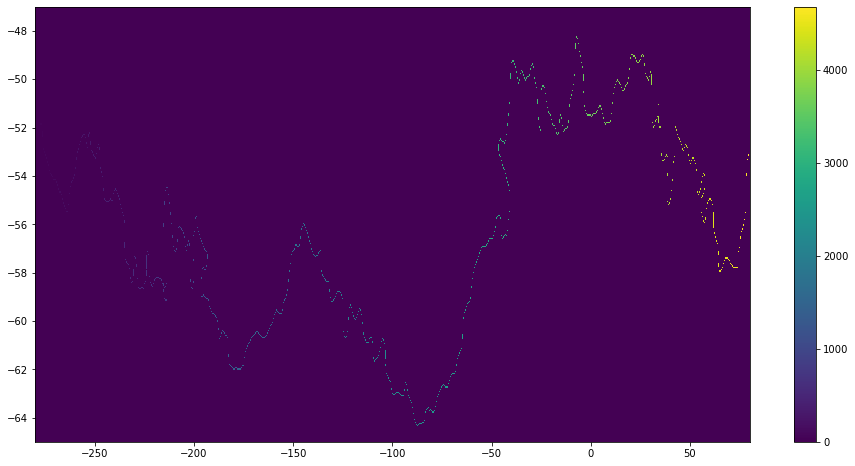

In [32]:
plt.figure(1,figsize=(16,8))
plt.pcolormesh(contour_mask.xt_ocean,contour_mask.yt_ocean,contour_mask)
plt.colorbar()

Now create masks above and below contour so that the direction of the contour can be determined

In [33]:
#contour_mask = contour_mask[1:-2][1:-2]
contour_mask_numbered = contour_mask

# fill in points to north of contour:
contour_masked_above = np.copy(contour_mask_numbered)
contour_masked_above1 = np.copy(contour_mask_numbered)

contour_masked_above1[-1,0] = -100
contour_masked_above[-1,0] = -100

# from top left:
for ii in range(len(contour_mask.xt_ocean)-1):
    for jj in range(len(contour_mask.yt_ocean))[::-1][:-1]:
        if contour_masked_above[jj,ii] == -100:
            if contour_masked_above[jj-1,ii] == 0:
                contour_masked_above[jj-1,ii] = -100
            if contour_masked_above[jj,ii+1] == 0:
                contour_masked_above[jj,ii+1] = -100
            # if contour_masked_above[jj-1,ii+1] == 0:
            #     contour_masked_above[jj-1,ii+1] = -100
#from top right:
for ii in range(len(contour_mask.xt_ocean))[::-1][:-1]:
    for jj in range(len(contour_mask.yt_ocean))[::-1][:-1]:
        if contour_masked_above[jj,ii] == -100:
            if contour_masked_above[jj-1,ii] == 0:
                contour_masked_above[jj-1,ii] = -100
            if contour_masked_above[jj,ii-1] == 0:
                contour_masked_above[jj,ii-1] = -100
            # if contour_masked_above[jj-1,ii-1] == 0:
            #     contour_masked_above[jj-1,ii-1] = -100
# # from bottom right:
for ii in range(len(contour_mask.xt_ocean))[::-1][:-1]:
    for jj in range(len(contour_mask.yt_ocean)-1):
        if contour_masked_above[jj,ii] == -100:
            if contour_masked_above[jj+1,ii] == 0:
                contour_masked_above[jj+1,ii] = -100
            if contour_masked_above[jj,ii-1] == 0:
                contour_masked_above[jj,ii-1] = -100
            # if contour_masked_above[jj+1,ii-1] == 0:
            #     contour_masked_above[jj+1,ii-1] = -100
# #from bottom left:
for ii in range(len(contour_mask.xt_ocean)-1):
    for jj in range(len(contour_mask.yt_ocean)-1):
        if contour_masked_above[jj,ii] == -100:
            if contour_masked_above[jj+1,ii] == 0:
                contour_masked_above[jj+1,ii] = -100
            if contour_masked_above[jj,ii+1] == 0:
                contour_masked_above[jj,ii+1] = -100
            # if contour_masked_above[jj+1,ii+1] == 0:
            #     contour_masked_above[jj+1,ii+1] = -100


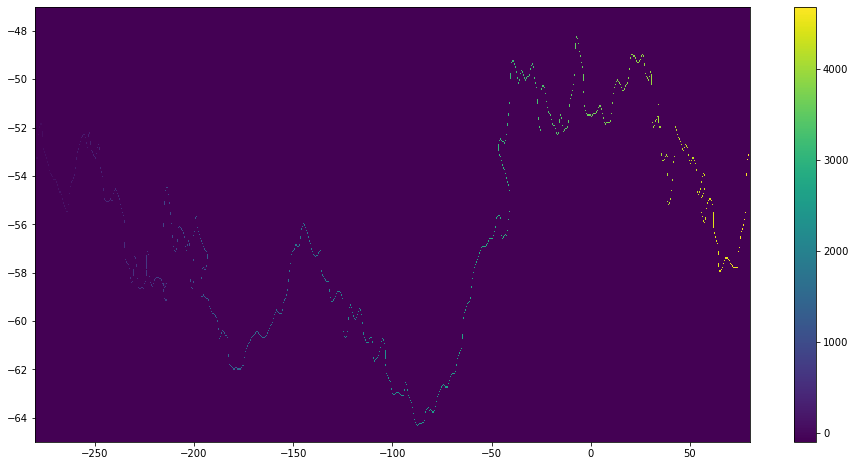

In [34]:
plt.figure(1,figsize=(16,8))
plt.pcolormesh(contour_mask.xt_ocean,contour_mask.yt_ocean, contour_masked_above)
plt.colorbar()


^^ meant to have -100 below the contour

In [35]:
mask_x_transport = np.zeros_like(contour_mask_numbered)
mask_y_transport = np.zeros_like(contour_mask_numbered)
mask_y_transport_numbered = np.zeros_like(contour_mask_numbered)
mask_x_transport_numbered = np.zeros_like(contour_mask_numbered)
# make halos:
contour_masked_above_halo = np.zeros((contour_masked_above.shape[0],
    contour_masked_above.shape[1]+2))
contour_masked_above_halo[:,0] = contour_masked_above[:,-1]
contour_masked_above_halo[:,1:-1] = contour_masked_above
contour_masked_above_halo[:,-1] = contour_masked_above[:,0]

new_number_count = 1
for mask_loc in range(1,int(np.max(contour_mask_numbered))+1):
    #if mask_loc%100 == 0:
    #    print('mask for x/y transport at point '+str(mask_loc))
    index_i = np.where(contour_mask_numbered==mask_loc)[1]
    index_j = np.where(contour_mask_numbered==mask_loc)[0]
    # if point above is towards Antarctica and point below is away from Antarctica:
    # take transport grid point to north of t grid:
    if (contour_masked_above[index_j+1,index_i]==0) and (contour_masked_above[index_j-1,index_i]!=0):
        mask_y_transport[index_j,index_i] = -1
        # important to do 
        mask_y_transport_numbered[index_j,index_i] = new_number_count
        new_number_count += 1
    # if point below is towards Antarctica and point above is away from Antarctica:
    # take transport grid point to south of t grid:
    elif (contour_masked_above[index_j-1,index_i]==0) and (contour_masked_above[index_j+1,index_i]!=0):
        mask_y_transport[index_j-1,index_i] = 1
        mask_y_transport_numbered[index_j-1,index_i] = new_number_count
        new_number_count += 1
    # if point to right is towards Antarctica and point to left is away from Antarctica:
    # zonal indices increased by 1 due to halos
    # take transport grid point on right of t grid:
    if (contour_masked_above_halo[index_j,index_i+2]==0) and (contour_masked_above_halo[index_j,index_i]!=0):
        mask_x_transport[index_j,index_i] = -1
        mask_x_transport_numbered[index_j,index_i] = new_number_count
        new_number_count += 1
    # if point to left is towards Antarctica and point to right is away from Antarctica:
    # take transport grid point on left of t grid:
    elif (contour_masked_above_halo[index_j,index_i]==0) and (contour_masked_above_halo[index_j,index_i+2]!=0):
        mask_x_transport[index_j,index_i-1] = 1
        mask_x_transport_numbered[index_j,index_i-1] = new_number_count
        new_number_count += 1

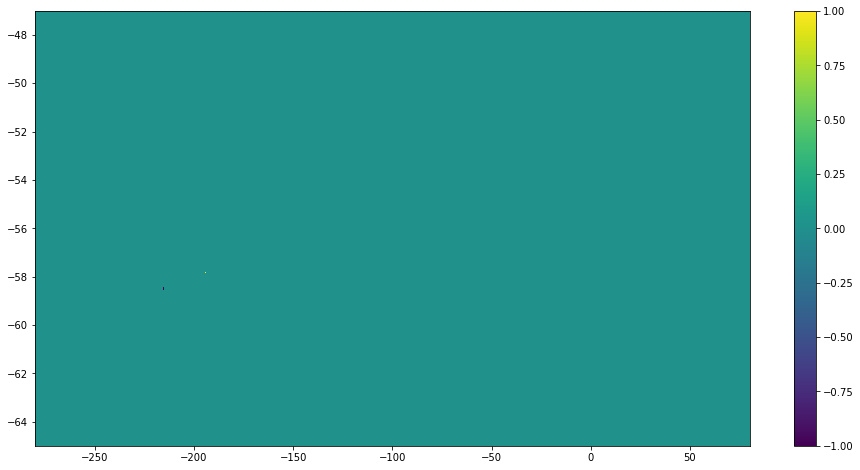

In [36]:
plt.figure(1,figsize=(16,8))
plt.pcolormesh(contour_mask.xt_ocean,contour_mask.yt_ocean,mask_x_transport)
plt.colorbar()

### Though it appeared that I fixed the holes in the contour, I must not have completely fixed it because the code cannot identify above and below the contour :( Therefore everything is 0.

### We now have the coordinates of the contours, and whether the x or y transport is needed to calculate cross-contour transport. 

We now proceed to calculate transports across the contour

### (carrying on with zeros for now)

In [37]:
## some grid data is required, a little complicated because these variables don't behave well with some 
dyt = cc.querying.getvar(expt, 'dyt',session, n=1, ncfile = 'ocean_grid.nc')
dxu = cc.querying.getvar(expt, 'dxu',session, n=1, ncfile = 'ocean_grid.nc')

# select latitude range:
dxu = dxu.sel(yu_ocean=lat_range)
dyt = dyt.sel(yt_ocean=lat_range)

In [38]:
mask_x_transport

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [41]:
# Convert contour masks to data arrays, so we can multiply them later.
# We need to ensure the lat lon coordinates correspond to the actual data location:
#       The y masks are used for vhrho, so like vhrho this should have dimensions (yu_ocean, xt_ocean).
#       The x masks are used for uhrho, so like uhrho this should have dimensions (yt_ocean, xu_ocean).
#       However the actual name will always be simply y_ocean/x_ocean irrespective of the variable
#       to make concatenation of transports in both direction and sorting possible.

mask_x_transport = xr.DataArray(mask_x_transport, coords = [('y_ocean', yt_ocean), ('x_ocean', xu_ocean)])
mask_y_transport = xr.DataArray(mask_y_transport, coords = [('y_ocean', yu_ocean), ('x_ocean', xt_ocean)])
mask_x_transport_numbered = xr.DataArray(mask_x_transport_numbered, coords = [('y_ocean', yt_ocean), ('x_ocean', xu_ocean)])
mask_y_transport_numbered = xr.DataArray(mask_y_transport_numbered, coords = [('y_ocean', yu_ocean), ('x_ocean', xt_ocean)])

TypeError: Using a DataArray object to construct a variable is ambiguous, please extract the data using the .data property.